# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.
 

In [60]:
import pandas as pd
import numpy as np

In [4]:
products = pd.read_csv('data/amazon_baby_subset.csv')

In [5]:
products = products.fillna({'review':''})

In [8]:
def remove_punctuation(text):
    import string
    return text.translate(string.punctuation)

In [9]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [50]:
important_words = pd.read_json('data/important_words.json')[0]
important_words = [str(s) for s in important_words]
important_words

['baby',
 'one',
 'great',
 'love',
 'use',
 'would',
 'like',
 'easy',
 'little',
 'seat',
 'old',
 'well',
 'get',
 'also',
 'really',
 'son',
 'time',
 'bought',
 'product',
 'good',
 'daughter',
 'much',
 'loves',
 'stroller',
 'put',
 'months',
 'car',
 'still',
 'back',
 'used',
 'recommend',
 'first',
 'even',
 'perfect',
 'nice',
 'bag',
 'two',
 'using',
 'got',
 'fit',
 'around',
 'diaper',
 'enough',
 'month',
 'price',
 'go',
 'could',
 'soft',
 'since',
 'buy',
 'room',
 'works',
 'made',
 'child',
 'keep',
 'size',
 'small',
 'need',
 'year',
 'big',
 'make',
 'take',
 'easily',
 'think',
 'crib',
 'clean',
 'way',
 'quality',
 'thing',
 'better',
 'without',
 'set',
 'new',
 'every',
 'cute',
 'best',
 'bottles',
 'work',
 'purchased',
 'right',
 'lot',
 'side',
 'happy',
 'comfortable',
 'toy',
 'able',
 'kids',
 'bit',
 'night',
 'long',
 'fits',
 'see',
 'us',
 'another',
 'play',
 'day',
 'money',
 'monitor',
 'tried',
 'thought',
 'never',
 'item',
 'hard',
 'plasti

In [51]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))


In [52]:
products['perfect']

0        0
1        0
2        0
3        1
4        0
        ..
53067    0
53068    0
53069    0
53070    0
53071    0
Name: perfect, Length: 53072, dtype: int64

In [53]:
valid_index = pd.read_json('data/module-4-assignment-validation-idx.json')[0].values
train_index  = pd.read_json('data/module-4-assignment-train-idx.json')[0].values


In [54]:
len(valid_index)

10711

In [55]:
validation_data = products.iloc[valid_index].reset_index(drop=True)

In [56]:
train_data = products.iloc[train_index].reset_index(drop=True)

In [57]:
def get_numpy_data(data, features, output):
    data['constant'] = 1 # add a constant column 

    # prepend variable 'constant' to the features list
    features = ['constant'] + features

    # select the columns of data_SFrame given by the ‘features’ list into the SFrame ‘features_sframe’
    features_matrix=data[features].to_numpy()

    # assign the column of data_sframe associated with the target to the variable ‘output_sarray’
    output_array = data[output].to_numpy()

    return(features_matrix, output_array)

In [58]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

In [61]:
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1/(1+np.exp(-score))
    
    # return predictions
    return predictions

In [174]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty,feature_is_constant):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature) 

    if not feature_is_constant:
        derivative = derivative - 2*l2_penalty*coefficient

    # Return the derivative
    return derivative

In [175]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    return lp

In [176]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            coefficients[j] += step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

In [ ]:
penalty_values =  [0, 4, 10, 1e2, 1e3, 1e5]
coef = []
initial_coefficients = np.zeros(194)
step_size = 5e-6
for i in penalty_values:
    coef.append(logistic_regression_with_L2(feature_matrix_train,
                                             sentiment_train, initial_coefficients, step_size, i, max_iter=501))

In [179]:
len(important_words)

193

In [180]:
table= pd.DataFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [181]:
add_coefficients_to_table(coef[0], 'coefficients [L2=0]')
add_coefficients_to_table(coef[1], 'coefficients [L2=4]')
add_coefficients_to_table(coef[2], 'coefficients [L2=10]')
add_coefficients_to_table(coef[3],  'coefficients [L2=1e2]')
add_coefficients_to_table(coef[4],  'coefficients [L2=1e3]')
add_coefficients_to_table(coef[5],  'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.070184,-0.069563,-0.068642,-0.056228,-0.002102,0.010482
1,baby,0.091208,0.091004,0.090704,0.086810,0.064944,0.001669
2,one,0.016803,0.016578,0.016247,0.012001,-0.002518,-0.001229
3,great,0.757890,0.753036,0.745885,0.654686,0.324473,0.006737
4,love,1.093872,1.086042,1.074515,0.928547,0.430865,0.008887
...,...,...,...,...,...,...,...
189,babies,0.007430,0.007450,0.007479,0.007913,0.007674,0.000150
190,won,0.006615,0.006549,0.006450,0.005202,0.001490,0.000017
191,tub,-0.172717,-0.171192,-0.168945,-0.140352,-0.048443,-0.000689
192,almost,-0.026058,-0.025806,-0.025435,-0.020669,-0.005412,-0.000115


In [182]:
table.sort_values('coefficients [L2=0]', ascending=False)

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
4,love,1.093872,1.086042,1.074515,0.928547,0.430865,0.008887
23,loves,1.082033,1.073286,1.060403,0.896515,0.355308,0.006111
8,easy,1.008062,1.000964,0.990517,0.858243,0.404921,0.008355
3,great,0.757890,0.753036,0.745885,0.654686,0.324473,0.006737
34,perfect,0.728262,0.721944,0.712632,0.593580,0.206385,0.003047
...,...,...,...,...,...,...,...
169,returned,-0.552112,-0.547114,-0.539746,-0.445443,-0.143605,-0.002049
97,money,-0.571756,-0.566956,-0.559886,-0.470136,-0.180188,-0.003133
114,return,-0.739412,-0.732860,-0.723207,-0.600361,-0.210947,-0.003438
106,disappointed,-0.743392,-0.736662,-0.726742,-0.599845,-0.193372,-0.002696


In [183]:
table.sort_values('coefficients [L2=0]', ascending=True)

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
113,waste,-0.756096,-0.749447,-0.739648,-0.614659,-0.212629,-0.003190
106,disappointed,-0.743392,-0.736662,-0.726742,-0.599845,-0.193372,-0.002696
114,return,-0.739412,-0.732860,-0.723207,-0.600361,-0.210947,-0.003438
97,money,-0.571756,-0.566956,-0.559886,-0.470136,-0.180188,-0.003133
169,returned,-0.552112,-0.547114,-0.539746,-0.445443,-0.143605,-0.002049
...,...,...,...,...,...,...,...
34,perfect,0.728262,0.721944,0.712632,0.593580,0.206385,0.003047
3,great,0.757890,0.753036,0.745885,0.654686,0.324473,0.006737
8,easy,1.008062,1.000964,0.990517,0.858243,0.404921,0.008355
23,loves,1.082033,1.073286,1.060403,0.896515,0.355308,0.006111


In [184]:
positive_words = table.sort_values('coefficients [L2=0]', ascending=False)['word'][0:5]
negative_words = table.sort_values('coefficients [L2=0]', ascending=True)['word'][0:5]


In [186]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')

    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table[table['word']==positive_words.values[i]].values[0][1:],
                 '-', label=positive_words.values[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table[table['word']==negative_words.values[i]].values[0][1:],'-',
                  label=negative_words.values[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()




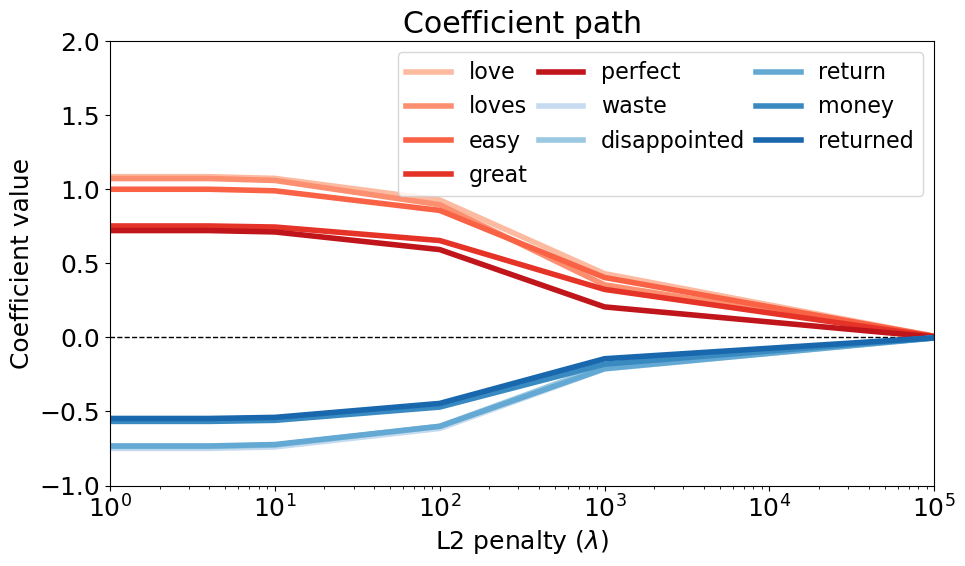

In [188]:
make_coefficient_plot(table, positive_words, negative_words, penalty_values)


## Measuring accuracy


In [189]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

In [191]:
# Training data
for i, l2 in enumerate(penalty_values):
    accuracy = get_classification_accuracy(feature_matrix_train, sentiment_train, coef[i])
    print("l2: ", l2, "; accuracy: ", accuracy)

l2:  0 ; accuracy:  0.7700715280564671
l2:  4 ; accuracy:  0.7699771015792828
l2:  10 ; accuracy:  0.7698354618635065
l2:  100.0 ; accuracy:  0.7683246382285593
l2:  1000.0 ; accuracy:  0.7572295271594155
l2:  100000.0 ; accuracy:  0.6534784353532731


In [192]:
# Test data
for i, l2 in enumerate(penalty_values):
    accuracy = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coef[i])
    print("l2: ", l2, "; accuracy: ", accuracy)

l2:  0 ; accuracy:  0.7664083652320045
l2:  4 ; accuracy:  0.7663150032676688
l2:  10 ; accuracy:  0.7664083652320045
l2:  100.0 ; accuracy:  0.7661282793389973
l2:  1000.0 ; accuracy:  0.7584725982634675
l2:  100000.0 ; accuracy:  0.644664363738213
